In [38]:
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark --iversions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import io
from utils.benchmark import Bench
from tqdm.notebook import tqdm

from utils.dgps import generate_benchmark_data
from utils.estimators import (
    twfe_fixest, 
    twfe_fixest_compressed, 
    twfe_statsmodels, 
    duck_mundlak, 
    event_study_fixest, 
    duck_mundlak_event, 
    event_study_statsmodels
)
from utils.benchmark import Bench
from itertools import product


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
sys       : 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:47:54) [MSC v.1941 64 bit (AMD64)]
matplotlib: 3.9.2
tqdm      : 4.66.4
seaborn   : 0.13.2
pandas    : 2.2.3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
sys       : 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:47:54) [MSC v.1941 64 bit (AMD64)]
matplotlib: 3.9.2
tqdm      : 4.66.4
seaborn   : 0.13.2
pandas    : 2.2.3



In [46]:
N_values = [10_000]
T_values = [14, 28, 42]
T0_values = [7]
iter = 3

all_benchmarks_df = pd.DataFrame()

# Initialize the tqdm progress bar for the outer loop
with tqdm(total=len(N_values) * len(T_values) * len(T0_values), desc="Processing benchmarks") as pbar:

    for N, T, T0 in product(N_values, T_values, T0_values):
        bench = Bench(N=N, T=T, T0=T0, iter=iter)

        # Suppress tqdm output in called functions for Jupyter
        temp_stdout = io.StringIO()
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = temp_stdout
        sys.stderr = temp_stdout
        try:
            if N * T <= 100_000_000:
                bench.mark(fun=twfe_statsmodels)
                bench.mark(fun=twfe_fixest_compressed, reps=1)    
            bench.mark(fun=twfe_fixest)
            bench.mark(fun=event_study_fixest)
            bench.mark(fun=duck_mundlak)
            bench.mark(fun=duck_mundlak_event)
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

        # Update the progress bar manually
        pbar.update(1)

        # Collect results
        bench_df = bench.to_dataframe()
        bench_df["N"] = N
        bench_df["T"] = T
        bench_df["T0"] = T0

        bench_df.to_csv(f"data/benchmark{N}_{T}_{T0}.csv")

        all_benchmarks_df = pd.concat(
            [all_benchmarks_df, bench_df], 
            axis=0
        )




Processing benchmarks:   0%|          | 0/3 [00:00<?, ?it/s]

Data loaded into DuckDB database: benchmarks.db
Data loaded into DuckDB database: benchmarks.db


Data loaded into DuckDB database: benchmarks.db
Data loaded into DuckDB database: benchmarks.db


## Load Data

In [41]:
import pandas as pd
import glob
import os

all_files = glob.glob(os.path.join("data", "*.csv"))
all_benchmarks_list = [pd.read_csv(file) for file in all_files]

all_benchmarks_df = pd.concat(all_benchmarks_list, axis = 0)

In [42]:
all_benchmarks_df_melted = all_benchmarks_df.melt(
    id_vars=['N', 'T', 'T0'],
    value_vars=models, 
    var_name='model',
    value_name='value'
)

median_run = (
    all_benchmarks_df_melted
        .groupby(["N", "T", "T0", "model"])
        .median()
        .reset_index()
)

In [44]:
median_run_pooled = median_run[median_run.model.isin([
    "duck_mundlak", 
    "twfe_fixest", 
    "twfe_statsmodels", 
    "twfe_fixest_compressed"
])]

median_run_event = median_run[median_run.model.isin([
])]


### Visualize Pooled Effect

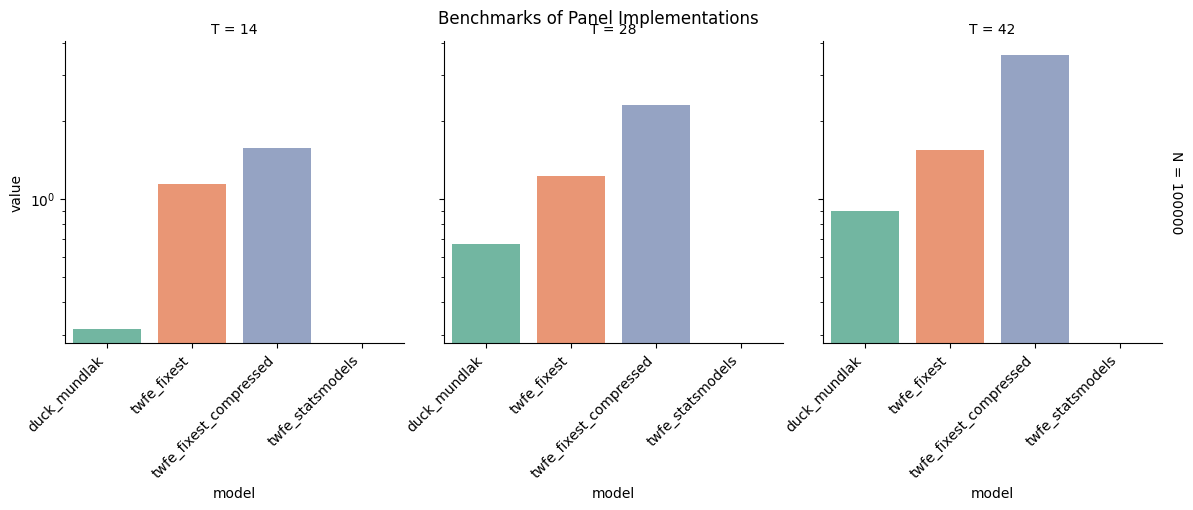

In [45]:
g = sns.FacetGrid(median_run_pooled, col="T", row="N", margin_titles=True, height=4, aspect=1)
g.map_dataframe(sns.barplot, x='model', y='value', hue='model', palette='Set2', legend=False)

# Adjust the x-axis labels' rotation for each subplot
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout
plt.yscale('log')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Benchmarks of Panel Implementations')

plt.show()
